In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [9]:
# !pip install nltk emoji scikit-learn matplotlib seaborn tensorflow==2.15.0
# Optional (for embeddings):
# !wget -q http://nlp.stanford.edu/data/glove.6B.zip && unzip -q glove.6B.zip -d glove

import os, re, json, glob, string, random, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight

import nltk
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Model # Updated import
from keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, GRU # Updated imports
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

EXTRACT_DIR = "/content/extracted_files"

Head:


,text,label
0,when modi promised “minimum government maximum...,0
1,talk all the nonsense and continue all the dra...,1
2,what did just say vote for modi welcome bjp t...,2
3,asking his supporters prefix chowkidar their n...,2
4,answer who among these the most powerful world...,2



Label distribution:


,count
label,
Positive,72249
Neutral,55211
Negative,35509


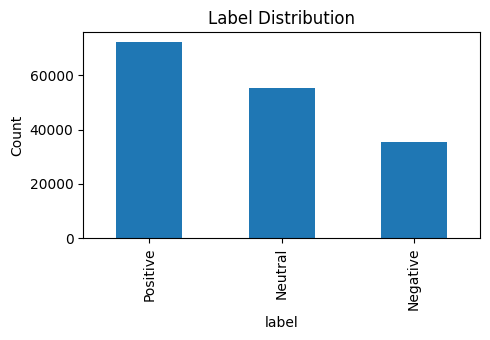

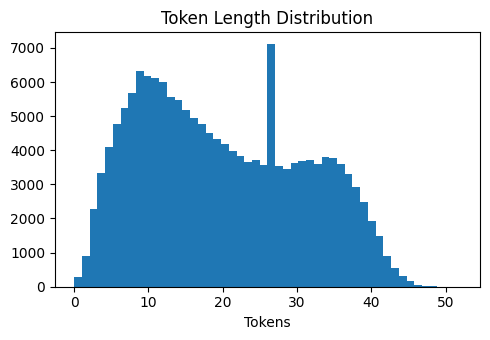


=== Outputs ===
X_text: (162969, 38)  (padded to) 38
X_meta: (162969, 7)
y: (162969,)  classes: ['Negative', 'Neutral', 'Positive']
Vocab size (capped): 40000
Saved EDA preview to: /content/eda_preview.csv


In [12]:
# === EDA + PREPROCESSING (Colab ready) ======================================
# If needed, install extras:
# !pip install nltk

import os, re, string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

import nltk
nltk.download('vader_lexicon', quiet=True)
from nltk.sentiment import SentimentIntensityAnalyzer

# ---------------- CONFIG ----------------
DATA_PATH = "/content/extracted_files/Twitter_Data.csv"  # <-- set your CSV path
TEXT_COL  = "clean_text"                                  # text column name
LABEL_COL = "category"                                    # label column name (-1,0,1)
LABEL_MAP = {-1.0: 0, 0.0: 1, 1.0: 2}                     # Neg, Neu, Pos
CLASS_NAMES = ["Negative", "Neutral", "Positive"]

MAX_VOCAB = 40000   # cap vocabulary size
PAD_PCT   = 95      # pad/truncate to 95th percentile length
# ----------------------------------------

# 1) Load and basic checks
df = pd.read_csv(DATA_PATH)
need = {TEXT_COL, LABEL_COL}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"Missing columns {missing}. Found {df.columns.tolist()}")

df = df[[TEXT_COL, LABEL_COL]].dropna().rename(columns={TEXT_COL: "text", LABEL_COL: "label"}).reset_index(drop=True)

# Label mapping to 0/1/2
if not set(df["label"].unique()).issubset(set(LABEL_MAP.keys())):
    raise ValueError(f"Label values {sorted(df['label'].unique())} not in expected keys {sorted(LABEL_MAP.keys())}")
df["label"] = df["label"].map(LABEL_MAP).astype(int)

print("Head:")
display(df.head(5))
print("\nLabel distribution:")
display(df["label"].map({0:"Negative",1:"Neutral",2:"Positive"}).value_counts())

# 2) Quick EDA
plt.figure(figsize=(5,3.5))
(df["label"].map({0:"Negative",1:"Neutral",2:"Positive"})).value_counts().plot(kind="bar")
plt.title("Label Distribution"); plt.ylabel("Count"); plt.tight_layout(); plt.show()

df["tokens"] = df["text"].astype(str).str.split()
df["len"] = df["tokens"].apply(len)
plt.figure(figsize=(5,3.5))
plt.hist(df["len"], bins=50)
plt.title("Token Length Distribution"); plt.xlabel("Tokens"); plt.tight_layout(); plt.show()

# 3) Cleaning + Meta Features
URL_RE   = re.compile(r"http\S+|www\.\S+")
HTML_RE  = re.compile(r"<.*?>")
NUM_RE   = re.compile(r"\d+")
EMOJI_RE = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)

def clean_text(s: str) -> str:
    s = str(s).lower()
    s = URL_RE.sub(" ", s)
    s = HTML_RE.sub(" ", s)
    s = s.translate(str.maketrans("", "", string.punctuation))
    s = NUM_RE.sub(" ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

vader = SentimentIntensityAnalyzer()

def meta_features(raw: str):
    t = str(raw)
    length = len(t)
    words  = len(t.split())
    exclam = t.count("!")
    quest  = t.count("?")
    caps_ratio = sum(1 for ch in t if ch.isupper()) / (len(t)+1e-6)
    emojis = len(EMOJI_RE.findall(t))
    vader_comp = vader.polarity_scores(t)["compound"]
    return length, words, exclam, quest, caps_ratio, emojis, vader_comp

df["clean"] = df["text"].apply(clean_text)

meta = np.vstack(df["text"].apply(meta_features).values)
meta_cols = ["char_len","word_len","exclam","question","caps_ratio","emoji_count","vader_comp"]
meta_df = pd.DataFrame(meta, columns=meta_cols)

scaler = StandardScaler()
X_meta = scaler.fit_transform(meta_df.values)

# 4) Tokenize + pad sequences
# Prefer tensorflow.keras; fallback to keras_preprocessing if needed
try:
    from tensorflow.keras.preprocessing.text import Tokenizer
    from tensorflow.keras.preprocessing.sequence import pad_sequences
except Exception:
    try:
        from keras_preprocessing.text import Tokenizer
        from keras_preprocessing.sequence import pad_sequences
    except Exception:
        raise ImportError(
            "Tokenizer import failed. Try:\n"
            "from tensorflow.keras.preprocessing.text import Tokenizer\n"
            "or install keras-preprocessing: !pip install keras-preprocessing"
        )

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df["clean"])
seqs = tokenizer.texts_to_sequences(df["clean"])
lens = np.array([len(x) for x in seqs])
MAX_LEN = int(np.percentile(lens, PAD_PCT)) if len(lens) else 50
MAX_LEN = max(MAX_LEN, 20)

X_text = pad_sequences(seqs, maxlen=MAX_LEN, padding="post", truncating="post")
y = df["label"].values

# 5) Outputs / sanity
print("\n=== Outputs ===")
print("X_text:", X_text.shape, " (padded to)", MAX_LEN)
print("X_meta:", X_meta.shape)
print("y:", y.shape, " classes:", CLASS_NAMES)
print("Vocab size (capped):", min(MAX_VOCAB, len(tokenizer.word_index)+1))

# Save a small preview for sanity / slides
preview = df[["text","clean","label"]].copy()
for i, c in enumerate(meta_cols):
    preview[c] = meta_df[c].values
preview_path = "/content/eda_preview.csv"
preview.to_csv(preview_path, index=False)
print(f"Saved EDA preview to: {preview_path}")
# ============================================================================



Class weights: {0: 1.5298459299937808, 1: 0.983910283984997, 2: 0.7518872875539946}


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_in             │ (None, 38)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ emb (Embedding)     │ (None, 38, 100)   │  4,000,000 │ text_in[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d   │ (None, 38, 100)   │          0 │ emb[0][0]         │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 38, 256)   │    234,496 │ spatial_dropout1… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 256)       │          0 │ bidirectional[0]… │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ bidirectional[0]… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 512)       │          0 │ global_max_pooli… │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ meta_in             │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │        256 │ meta_in[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 160)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │     10,304 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 3)         │        195 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,310,915 (16.44 MB)

 Trainable params: 4,310,915 (16.44 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.8241 - loss: 0.4593
Epoch 1: val_loss improved from inf to 0.12502, saving model to /content/bilstm_best.keras
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 674s 323ms/step - accuracy: 0.8242 - loss: 0.4592 - val_accuracy: 0.9650 - val_loss: 0.1250 - learning_rate: 0.0020
Epoch 2/20
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.9683 - loss: 0.1191
Epoch 2: val_loss did not improve from 0.12502
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 697s 330ms/step - accuracy: 0.9683 - loss: 0.1191 - val_accuracy: 0.9643 - val_loss: 0.1294 - learning_rate: 0.0020
Epoch 3/20
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9788 - loss: 0.0817
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0010000000474974513.

Epoch 3: val_loss did not improve from 0.12502
2038/2038 ━━━━━━━━━━━━━━━━━━━━ 680s 329ms/step - accuracy: 0.9788 - loss: 0.0817 - val_accuracy: 0.9536 - val_loss: 0.1746 - learning_rate: 0.0020
Epoch 4/20
2038/2038 ━━━━━━

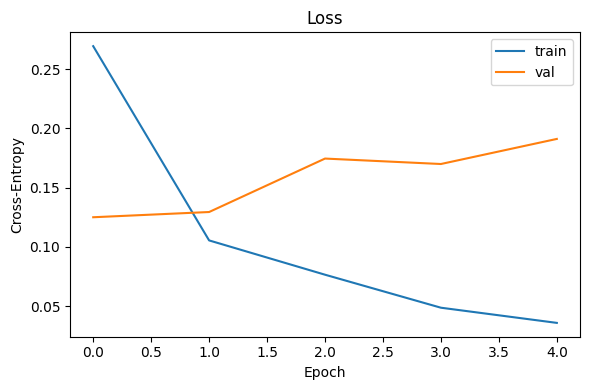

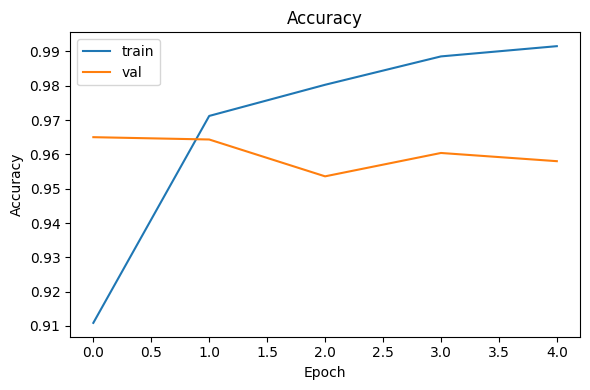


=== Classification Report (Test) ===
              precision    recall  f1-score   support

    Negative     0.9400    0.9440    0.9420      3551
     Neutral     0.9907    0.9698    0.9801      5521
    Positive     0.9606    0.9741    0.9673      7225

    accuracy                         0.9661     16297
   macro avg     0.9638    0.9626    0.9631     16297
weighted avg     0.9663    0.9661    0.9661     16297



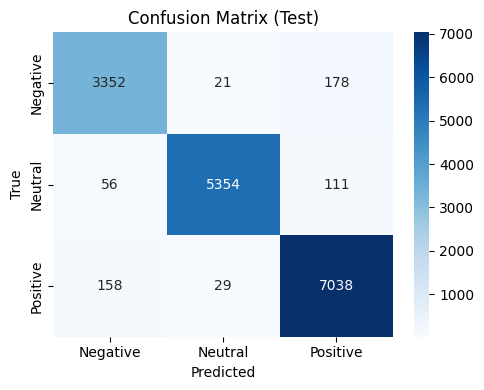

Macro ROC-AUC (Test): 0.9955

Saved: /content/bilstm_final.keras, /content/tokenizer.json, /content/meta_scaler.pkl, /content/label_map.json

Sample inference:
- This policy greatly simplifies compliance for small businesses.  ->  Positive  (probs: [0.009 0.005 0.986])
- Unclear and confusing changes; needs more clarity.  ->  Positive  (probs: [0.187 0.213 0.6  ])
- The increased penalties are unacceptable and unfair.  ->  Negative  (probs: [1. 0. 0.])


In [13]:
# === TRAIN / EVALUATE BiLSTM (Colab ready) ==================================
# Requirements: X_text, X_meta, y, MAX_LEN, CLASS_NAMES, tokenizer, scaler
# Tip: If you see GPU out-of-memory, reduce LSTM units or batch_size.

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import tensorflow as tf
from tensorflow.keras import layers, regularizers, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

# 1) Stratified splits
Xtr, Xtmp, Mtr, Mtmp, ytr, ytmp = train_test_split(
    X_text, X_meta, y, test_size=0.2, stratify=y, random_state=RANDOM_SEED
)
Xva, Xte, Mva, Mte, yva, yte = train_test_split(
    Xtmp, Mtmp, ytmp, test_size=0.5, stratify=ytmp, random_state=RANDOM_SEED
)

# 2) Class weights (handle imbalance)
classes = np.unique(ytr)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=ytr)
CLASS_WEIGHTS = {int(c): float(w) for c, w in zip(classes, class_weights)}
print("Class weights:", CLASS_WEIGHTS)

# 3) Build regularized BiLSTM model (two-input: text + meta)
def build_bilstm_model(
    vocab_size: int,
    max_len: int,
    num_meta: int,
    num_classes: int,
    emb_dim: int = 100,
    l2_reg: float = 1e-4,
    lstm_units: int = 128,
    text_dropout: float = 0.2,
    dense_dropout: float = 0.3,
):
    # Text branch
    text_in = layers.Input(shape=(max_len,), name="text_in")
    emb = layers.Embedding(vocab_size, emb_dim, name="emb")(text_in)
    x = layers.SpatialDropout1D(text_dropout)(emb)
    x = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)
    )(x)
    x = layers.Concatenate()([layers.GlobalMaxPooling1D()(x), layers.GlobalAveragePooling1D()(x)])
    x = layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(x)
    x = layers.Dropout(0.4)(x)

    # Meta branch
    meta_in = layers.Input(shape=(num_meta,), name="meta_in")
    m = layers.Dense(32, activation="relu")(meta_in)
    m = layers.Dropout(dense_dropout)(m)

    # Merge branches
    h = layers.Concatenate()([x, m])
    h = layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(l2_reg))(h)
    h = layers.Dropout(dense_dropout)(h)

    out = layers.Dense(num_classes, activation="softmax")(h)

    model = Model(inputs=[text_in, meta_in], outputs=out)
    opt = tf.keras.optimizers.Adam(learning_rate=2e-3, clipnorm=1.0)
    model.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

vocab_size = int(np.max(X_text)) + 1  # conservative upper bound for embedding matrix
num_meta = X_meta.shape[1]
num_classes = len(CLASS_NAMES)

model = build_bilstm_model(
    vocab_size=vocab_size,
    max_len=MAX_LEN,
    num_meta=num_meta,
    num_classes=num_classes,
)
model.summary()

# 4) Callbacks
CKPT_PATH = "/content/bilstm_best.keras"
cbs = [
    EarlyStopping(monitor="val_loss", patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-5, verbose=1),
    ModelCheckpoint(CKPT_PATH, monitor="val_loss", save_best_only=True, verbose=1),
]

# 5) Train
history = model.fit(
    {"text_in": Xtr, "meta_in": Mtr},
    ytr,
    validation_data=({"text_in": Xva, "meta_in": Mva}, yva),
    epochs=20,
    batch_size=64,
    class_weight=CLASS_WEIGHTS,
    callbacks=cbs,
    verbose=1,
)

# 6) Plot training curves
plt.figure(figsize=(6,4))
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.title("Loss"); plt.xlabel("Epoch"); plt.ylabel("Cross-Entropy"); plt.legend(); plt.tight_layout(); plt.show()

plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.title("Accuracy"); plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.legend(); plt.tight_layout(); plt.show()

# 7) Evaluate on test set
probs = model.predict({"text_in": Xte, "meta_in": Mte}, verbose=0)
preds = probs.argmax(axis=1)

print("\n=== Classification Report (Test) ===")
print(classification_report(yte, preds, target_names=CLASS_NAMES, digits=4))

cm = confusion_matrix(yte, preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
plt.title("Confusion Matrix (Test)"); plt.xlabel("Predicted"); plt.ylabel("True"); plt.tight_layout(); plt.show()

# Multi-class ROC-AUC (macro, one-vs-rest)
try:
    yte_oh = tf.keras.utils.to_categorical(yte, num_classes=num_classes)
    auc_macro = roc_auc_score(yte_oh, probs, average="macro", multi_class="ovr")
    print("Macro ROC-AUC (Test):", round(auc_macro, 4))
except Exception as e:
    print("ROC-AUC skipped:", e)

# 8) Save artifacts (model + tokenizer + scaler + label map)
import json, joblib
model.save("/content/bilstm_final.keras")
with open("/content/tokenizer.json", "w") as f:
    f.write(tokenizer.to_json())
joblib.dump(scaler, "/content/meta_scaler.pkl")
with open("/content/label_map.json", "w") as f:
    json.dump({"classes": CLASS_NAMES}, f)

print("\nSaved: /content/bilstm_final.keras, /content/tokenizer.json, /content/meta_scaler.pkl, /content/label_map.json")

# 9) Simple inference helper
from tensorflow.keras.preprocessing.sequence import pad_sequences

def predict_texts(texts, tokenizer, scaler, max_len=MAX_LEN):
    # Use the same cleaning + meta feature fns from EDA cell:
    import re, string
    URL_RE   = re.compile(r"http\S+|www\.\S+")
    HTML_RE  = re.compile(r"<.*?>")
    NUM_RE   = re.compile(r"\d+")
    EMOJI_RE = re.compile("[\U00010000-\U0010ffff]", flags=re.UNICODE)

    def clean_text(s):
        s = str(s).lower()
        s = URL_RE.sub(" ", s)
        s = HTML_RE.sub(" ", s)
        s = s.translate(str.maketrans("", "", string.punctuation))
        s = NUM_RE.sub(" ", s)
        s = re.sub(r"\s+", " ", s).strip()
        return s

    from nltk.sentiment import SentimentIntensityAnalyzer
    sia = SentimentIntensityAnalyzer()

    def meta_features(raw):
        t = str(raw)
        length = len(t)
        words  = len(t.split())
        exclam = t.count("!")
        quest  = t.count("?")
        caps_ratio = sum(1 for ch in t if ch.isupper()) / (len(t)+1e-6)
        emojis = len(EMOJI_RE.findall(t))
        vader_comp = sia.polarity_scores(t)["compound"]
        return [length, words, exclam, quest, caps_ratio, emojis, vader_comp]

    cleans = [clean_text(t) for t in texts]
    seqs = tokenizer.texts_to_sequences(cleans)
    X_txt = pad_sequences(seqs, maxlen=max_len, padding="post", truncating="post")

    meta_list = np.array([meta_features(t) for t in texts], dtype=np.float32)
    X_m = scaler.transform(meta_list)

    p = model.predict({"text_in": X_txt, "meta_in": X_m}, verbose=0)
    idx = p.argmax(axis=1)
    return [{"text": t, "pred": CLASS_NAMES[i], "probs": p[j].tolist()} for j, (t, i) in enumerate(zip(texts, idx))]

# Example:
examples = [
    "This policy greatly simplifies compliance for small businesses.",
    "Unclear and confusing changes; needs more clarity.",
    "The increased penalties are unacceptable and unfair."
]
print("\nSample inference:")
for out in predict_texts(examples, tokenizer, scaler):
    print(f"- {out['text']}  ->  {out['pred']}  (probs: {np.round(out['probs'], 3)})")
# ============================================================================
